In [1]:
from extractBofs import extractBofs
import os
import numpy as np
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Ruta de las nubes de puntos divididas en clases
ply_dir = "Proyecto_AYUDAME_Datasets/AYUDAME_02/zones"

dir_classes = os.listdir(ply_dir)
dir_classes.sort()

bofs = [] # Lista que contendrá todas las BOFs extraidas
targets = [] # Lista que contendrá las clases asignadas a cada BOF

num_classes = len(dir_classes)


# Iteración sobre las clases
for class_number in range(12,num_classes): # Solo me interesan las zonas 12 para arriba
    print(f"Extracting BOFs from class {class_number}...")
    dir_class = dir_classes[class_number]
    current_class_dir = os.listdir(ply_dir+"/"+dir_class)
    current_class_dir.sort()

    # Contador del número de bofs extraidas por archivo
    num_bofs_extracted = 0

    # Iteración sobre los elementos de las clases
    for ply_file in tqdm(current_class_dir):
        # Construye la ruta hacia cada archivo ply
        dir_ply_file = ply_dir+"/"+dir_class+"/"+ply_file
        # Extrae las BOFs de la nube de puntos
        ply_bofs = extractBofs(dir_ply_file,axis=2,method=2,layers=3)
        bofs.extend(ply_bofs)
        num_bofs_extracted += len(ply_bofs)

    # Asignación de clases
    class_target = np.ones(num_bofs_extracted) * class_number
    targets.append(class_target)

# Se transforman las listas obtenidas a arreglos de numpy
bofs_np = np.vstack(bofs)
targets_np = np.concatenate(targets)

Extracting BOFs from class 12...


100%|██████████| 105/105 [00:03<00:00, 27.72it/s]


Extracting BOFs from class 13...


100%|██████████| 105/105 [00:01<00:00, 62.73it/s]


Extracting BOFs from class 14...


100%|██████████| 105/105 [00:00<00:00, 142.02it/s]


Extracting BOFs from class 15...


100%|██████████| 105/105 [00:00<00:00, 120.55it/s]


Extracting BOFs from class 16...


100%|██████████| 105/105 [00:01<00:00, 78.49it/s]


Extracting BOFs from class 17...


100%|██████████| 105/105 [00:05<00:00, 20.41it/s]


In [3]:
bofs = bofs_np
targets = targets_np

In [4]:
classes,count_classes = np.unique(targets, return_counts=True)
print(f"Clases:           {classes}")
print(f"Conteo por clase: {count_classes}")

Clases:           [12. 13. 14. 15. 16. 17.]
Conteo por clase: [ 80  23   2  23  38 105]


Se realiza la asociación de clases de acuerdo a la siguiente tabla

|Zona AYUDAME_01    | Zona   AYUDAME_02|
|--------------|--------------|
|01            |    12        |
|06 |               13|
|06 |               14|
|07 |               15|
|08 |               16|
|08 |               17|

In [5]:
targets = np.where(targets == 12,1,targets)
targets = np.where(targets == 13,6,targets)
targets = np.where(targets == 14,6,targets)
targets = np.where(targets == 15,7,targets)
targets = np.where(targets == 16,8,targets)
targets = np.where(targets == 17,8,targets)

In [6]:
classes,count_classes = np.unique(targets, return_counts=True)
print(f"Clases:           {classes}")
print(f"Conteo por clase: {count_classes}")

Clases:           [1. 6. 7. 8.]
Conteo por clase: [ 80  25  23 143]


In [7]:
targets_oh = keras.utils.to_categorical(targets, 9)
print(targets_oh[:3], targets[:3])

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]] [1. 1. 1.]


## Fully connected neural network

In [8]:
model = keras.models.load_model("BOF_nn_model_iimas.h5")

2022-06-02 10:54:11.385395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 normalization (Normalizatio  (None, 180)              0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 360)               65160     
                                                                 
 dense_1 (Dense)             (None, 540)               194940    
                                                                 
 dense_2 (Dense)             (None, 360)               194760    
                                                                 
 dense_3 (Dense)             (None, 180)               64980     
                                                             

In [10]:
loss, acc = model.evaluate(x=bofs,y=targets_oh)
print("loss: %.3f" % loss)
print("acc : %.3f" % acc)

9/9 [==============================] - 0s 6ms/step - loss: 9.0081 - accuracy: 0.2066 
loss: 9.008
acc : 0.207


In [11]:
predictions = model.predict(bofs)
predictions.shape

(271, 9)

In [12]:
targets_pred = np.argmax(predictions,axis=1)
targets_pred.shape

(271,)

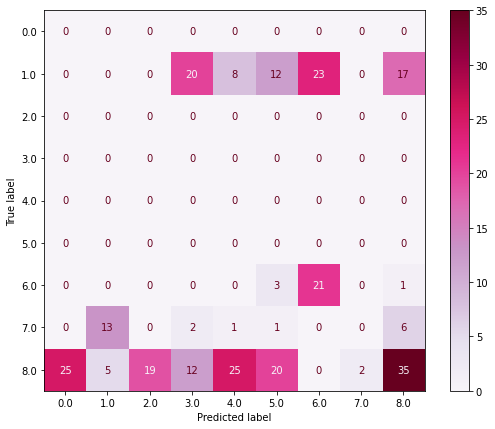

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=targets,y_pred=targets_pred,
                                              ax=ax,cmap='PuRd')
plt.show()

A continuación se imprime un reporte de las metricas más relevantes de la clasificación, las cuales son:

- Precisión (precision): $\frac{tp}{tp + fp}$. La habilidad del clasificador para no etiquetar como positiva una muestra que es negativa.

- Exhaustividad (recall): $\frac{tp}{tp + fn}$. La habilidad del clasificador de encontrar todas las muestras positivas.

- Medida F ($F_\beta$ score): Media armónica de la precisión y exhaustividad, dónde el mejor valor es 1 y el peor 0.

[Más información](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [14]:
print(classification_report(y_true=targets,y_pred=targets_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00        80
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.48      0.84      0.61        25
         7.0       0.00      0.00      0.00        23
         8.0       0.59      0.24      0.35       143

    accuracy                           0.21       271
   macro avg       0.12      0.12      0.11       271
weighted avg       0.36      0.21      0.24       271



/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

In [15]:
targets_oh = keras.utils.to_categorical(targets, 9)
print(targets_oh[:3], targets[:3])

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]] [1. 1. 1.]


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 normalization (Normalizatio  (None, 180)              0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 360)               65160     
                                                                 
 dense_1 (Dense)             (None, 540)               194940    
                                                                 
 dense_2 (Dense)             (None, 360)               194760    
                                                                 
 dense_3 (Dense)             (None, 180)               64980     
                                                             

In [17]:
loss, acc = model.evaluate(x=bofs,y=targets_oh)
print("loss: %.3f" % loss)
print("acc : %.3f" % acc)

9/9 [==============================] - 0s 4ms/step - loss: 9.0081 - accuracy: 0.2066 
loss: 9.008
acc : 0.207


In [18]:
predictions = model.predict(bofs)
predictions.shape

(271, 9)

In [19]:
targets_pred = np.argmax(predictions,axis=1)
targets_pred.shape

(271,)

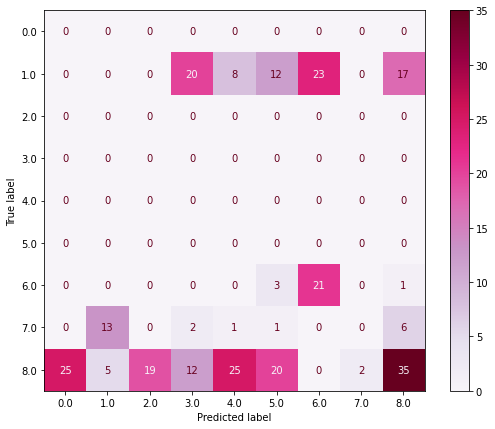

In [20]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=targets,y_pred=targets_pred,
                                              ax=ax,cmap='PuRd')
plt.show()

A continuación se imprime un reporte de las metricas más relevantes de la clasificación, las cuales son:

- Precisión (precision): $\frac{tp}{tp + fp}$. La habilidad del clasificador para no etiquetar como positiva una muestra que es negativa.

- Exhaustividad (recall): $\frac{tp}{tp + fn}$. La habilidad del clasificador de encontrar todas las muestras positivas.

- Medida F ($F_\beta$ score): Media armónica de la precisión y exhaustividad, dónde el mejor valor es 1 y el peor 0.

[Más información](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [21]:
print(classification_report(y_true=targets,y_pred=targets_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00        80
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.48      0.84      0.61        25
         7.0       0.00      0.00      0.00        23
         8.0       0.59      0.24      0.35       143

    accuracy                           0.21       271
   macro avg       0.12      0.12      0.11       271
weighted avg       0.36      0.21      0.24       271



/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/miniconda3/envs/rgbd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
